In [181]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.10.0


In [182]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())


Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [183]:
import tensorflow as tf
print("CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
print("cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])



CUDA Version: 64_112
cuDNN Version: 64_8


In [184]:
pip list > working_workspace_requirements.txt


Note: you may need to restart the kernel to use updated packages.


# Day 1

1. re (Regular Expressions): Helps in pattern matching and text preprocessing.
2. sklearn.utils.shuffle: Randomly shuffles datasets to avoid biases in training.
3. tensorflow.keras.layers:
    1. Input: Defines input layers for neural networks.
    2. LSTM: Long Short-Term Memory layer for sequential data processing (e.g., NLP).
    3. Embedding: Converts categorical data into dense vector representations.
    4. Dense: Fully connected layer for deep learning models.
    5. Bidirectional: Wraps LSTM to process input in both forward and backward directions.
4. tensorflow.keras.models.Model: Defines and compiles deep learning models.
5. string & digits (from string module): Used for string operations, including handling punctuation and digits.

In [185]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Bidirectional
from tensorflow.keras.models import Model

In [186]:
data=pd.read_csv(r'C:\Users\User\Downloads\Dataset_English_Hindi.csv\Dataset_English_Hindi.csv')

In [187]:
data=data.iloc[:3000,:]

In [188]:
data.head()

,English,Hindi
0,Help!,बचाओ!
1,Jump.,उछलो.
2,Jump.,कूदो.
3,Jump.,छलांग.
4,Hello!,नमस्ते।


In [189]:
data['English'].isnull().value_counts()

English
False    3000
Name: count, dtype: int64

In [190]:
data['Hindi'].isnull().value_counts()

Hindi
False    3000
Name: count, dtype: int64

In [191]:
data.dropna(inplace=True)

In [192]:
data.shape

(3000, 2)

In [193]:
data.describe()

,English,Hindi
count,3000,3000
unique,2793,2922
top,Is your father a teacher?,उसे सब पसंद करते हैं।
freq,9,4


# Preprocessing

In [194]:
# Convert everything into LOWER case
data.English=data.English.apply(lambda x: x.lower())
data.Hindi=data.Hindi.apply(lambda x: x.lower())

# Remove Quotes
data.English=data.English.apply(lambda x: re.sub("'",'',x))
data.Hindi=data.Hindi.apply(lambda x: re.sub("'",'',x))

# Set of all special characters
exclude=set(string.punctuation)

# Remove all Special characters stored in the above set 'exclude'
data.English=data.English.apply(lambda x:''.join(ch for ch in x if ch not in exclude))
data.Hindi=data.Hindi.apply(lambda x:''.join(ch for ch in x if ch not in exclude))

#Removing Hindi punctuations explicitly
hindi_punctuation = '।॥“”‘’'
data.Hindi = data.Hindi.apply(lambda x: re.sub(f"[{hindi_punctuation}]", "", x))


# Remove all numbers from the text
remove_digits=str.maketrans('','',digits)#creates a translation table that removes all digits (0-9) from a string when used with .translate().
data.English=data.English.apply(lambda x: x.translate(remove_digits))
data.Hindi = data.Hindi.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove all extra spaces
data.English=data.English.apply(lambda x: x.strip())
data.Hindi=data.Hindi.apply(lambda x: x.strip())
data.English=data.English.apply(lambda x : re.sub(' +',' ',x))
data.Hindi=data.Hindi.apply(lambda x : re.sub(' +',' ',x))

data.Hindi=data.Hindi.apply(lambda x: 'START_ '+x+' _END')


Text Preprocessing Summary
1. Lowercasing – Converts all text to lowercase.
2. Remove Quotes & Special Characters – Eliminates punctuation and single quotes.
3. Remove Numbers – Deletes English digits (0-9) and specific Hindi numerals.
4. Remove Extra Spaces – Strips leading/trailing spaces and replaces multiple spaces with a single one.
5. Add Start & End Tokens (Hindi) – Wraps Hindi text with "START_+ " and " _END" for sequence modeling.

In [195]:
data.sample(5)

,English,Hindi
408,its very hot here,START_ यहाँ बहुत गरम है _END
2687,im not saying that your answers are always wrong,START_ मैं यह नहीं कह रही हूँ कि तुम्हारे उत्त...
1773,please pardon me for coming late,START_ मुझे देर से आने के लिए माफ़ कीजिएगा _END
2751,we communicate with each other by telephone ev...,START_ हम रोज़ एकदूसरे से फ़ोन पर बात करते हैं...
536,he married for money,START_ उसने पैसों के लिए शादी की _END


In [196]:
# English Vocabulary
english_vocab = set()
for sentence in data.English:
    for word in sentence.split():
        english_vocab.add(word)  # No need for the extra 'if' check

# Hindi Vocabulary
hindi_vocab = set()
for sentence in data.Hindi:
    for word in sentence.split():
        hindi_vocab.add(word)  # No need for the extra 'if' check


In [197]:
# Max Length of Source sequence
length_list=[]
for l in data.English:
    length_list.append(len(l.split(' ')))
max_length_src=np.max(length_list)

# Max Length of Target sequence
length_list=[]
for l in data.Hindi:
    length_list.append(len(l.split(' ')))
max_length_tar=np.max(length_list)


In [198]:
input_words=sorted(list(english_vocab))
target_words=sorted(list(hindi_vocab))

num_encoder_tokens=len(english_vocab)
num_decoder_tokens=len(hindi_vocab)
num_encoder_tokens,num_decoder_tokens

# for 0 padding
num_decoder_tokens+=1


In [199]:
num_encoder_tokens

2937

In [200]:
input_token_index=dict([word,i+1] for i,word in enumerate(input_words))
target_token_index=dict([word,i+1] for i,word in enumerate(target_words))

reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [201]:
variables={
    'input_token_index':input_token_index,
    'target_token_index':target_token_index,
    'reverse_input_char_index':reverse_input_char_index,
    'reverse_target_char_index':reverse_target_char_index,
    'num_encoder_tokens':num_encoder_tokens,
    'num_decoder_tokens':num_decoder_tokens,
    'max_length_src':max_length_src,
    'max_length_tar':max_length_tar
}

In [202]:
import pickle

In [203]:
with open('variables.pkl', 'wb') as file:
    pickle.dump(variables, file)

print("Variables saved to 'variables.pkl'.")

Variables saved to 'variables.pkl'.


In [204]:
for i in ['hello','i','am','learning','translation']:
    print(input_token_index.get(i,0))
    

1193
1263
90
1454
2654


In [205]:
data=shuffle(data)
data.head()

,English,Hindi
184,are you at home,START_ तुम घर पे हो क्या _END
1385,i like both science and math,START_ मुझे विज्ञान और गणित दोनों पसंद हैं _END
1408,please wait for five minutes,START_ कृपया पाँच मिनट इंतेज़ार करें _END
312,i cried all night,START_ मैं पूरी रात रोई _END
2234,i am fully convinced of your innocence,START_ मुझे तुम्हारे बेगुनाह होने पर पूरा यकीन...


# Preprocessing Complete

In [206]:
# Save as pickle
with open("preprocessed_data.pkl", "wb") as f:
    pickle.dump(data, f)

# Day 2

In [207]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import pickle

In [208]:
import pickle
# Load it back
with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

data.head()

,English,Hindi
184,are you at home,START_ तुम घर पे हो क्या _END
1385,i like both science and math,START_ मुझे विज्ञान और गणित दोनों पसंद हैं _END
1408,please wait for five minutes,START_ कृपया पाँच मिनट इंतेज़ार करें _END
312,i cried all night,START_ मैं पूरी रात रोई _END
2234,i am fully convinced of your innocence,START_ मुझे तुम्हारे बेगुनाह होने पर पूरा यकीन...


In [209]:
data['inp_len']=data.English.apply(lambda x:len(x.split()))
data['tar_len']=data.Hindi.apply(lambda x:len(x.split()))

In [210]:
data.sample(5)

,English,Hindi,inp_len,tar_len
2017,a hundred years is called a century,START_ सौ सालों को एक शतक बुलाया जाता है _END,7,10
2101,could you bring me another hot towel,START_ मेरे लिए एक और गरम तौलिया ला सकते हैं क...,7,12
1477,i have not seen him in months,START_ मैंने उसे महीनों से नहीं देखा है _END,7,9
210,i want a guitar,START_ मुझे गिटार चाहिए _END,4,5
2282,he has invited me to attend his wedding,START_ उसने मुझे अपनी शादी में आने का का न्योत...,8,13


In [211]:
X,y=data.English,data.Hindi
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape

((2400,), (600,))

In [212]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [213]:
# Load from pickle file
with open('variables.pkl', 'rb') as file:
    loaded_variables = pickle.load(file)
print('Variables Loaded successfully')

Variables Loaded successfully


In [214]:
# Access the variables after loading
num_encoder_tokens = loaded_variables['num_encoder_tokens']
num_decoder_tokens = loaded_variables['num_decoder_tokens']
max_length_src = loaded_variables['max_length_src']
max_length_tar = loaded_variables['max_length_tar']

input_token_index=loaded_variables['input_token_index']
target_token_index=loaded_variables['target_token_index']
reverse_input_char_index=loaded_variables['reverse_input_char_index']
reverse_target_char_index=loaded_variables['reverse_target_char_index']

In [215]:
def generate_batch(X, y, batch_size):
    while True:
        for j in range(0, len(X), batch_size):
            current_batch_size = min(batch_size, len(X) - j)
            
            encoder_input_data = np.zeros((current_batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((current_batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((current_batch_size, max_length_tar, num_decoder_tokens), dtype='float32')

            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                input_words = input_text.split()
                target_words = target_text.split()
                
                # Fill encoder_input_data
                for t, word in enumerate(input_words):
                    encoder_input_data[i, t] = input_token_index.get(word, 0)  # Handle unknown words
                
                # Fill decoder_input_data and decoder_target_data
                for t, word in enumerate(target_words):
                    decoder_input_data[i, t] = target_token_index.get(word, 0)
                    if t > 0:
                        decoder_target_data[i, t - 1, target_token_index.get(word, 0)] = 1.0  # One-hot

            # print(f"Batch generated: encoder_input_data shape: {encoder_input_data.shape}, "
            #       f"decoder_input_data shape: {decoder_input_data.shape}, "
            #       f"decoder_target_data shape: {decoder_target_data.shape}")
             # Reverse encoder input sequences
            #encoder_input_data_reversed = np.array([seq[::-1] for seq in encoder_input_data])

            yield ([encoder_input_data, decoder_input_data], decoder_target_data)

# Understanding `decoder_target_data` Structure

## Given Conditions:
- `batch_size = 3`
- `max_length_tar = 2`
- `num_decoder_tokens = 3`

## Target Vocabulary and One-Hot Encoding:
| Token | One-Hot Encoding |
|--------|----------------|
| A      | [1 0 0]       |
| B      | [0 1 0]       |
| C      | [0 0 1]       |

## Example Sentences and Their One-Hot Representations:
We have three sentences: `AB`, `BC`, and `AC`.

```python
decoder_target_data = np.array([
    [[1, 0, 0], [0, 1, 0]],  # Sentence: "AB"
    [[0, 1, 0], [0, 0, 1]],  # Sentence: "BC"
    [[1, 0, 0], [0, 0, 1]]   # Sentence: "AC"
])


In [216]:
latent_dim=100

In [217]:
from tensorflow.keras.layers import concatenate


In [218]:
# Encoder Input
encoder_inputs = Input(shape=(None,))  

# Embedding Layer
enc_emb = Embedding(input_dim=num_encoder_tokens+1, output_dim=latent_dim, mask_zero=True)(encoder_inputs)

# First Bidirectional LSTM Layer (returns sequences)
encoder_lstm1 = Bidirectional(LSTM(units=latent_dim, return_sequences=True, return_state=True))
encoder_outputs1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

# Second Bidirectional LSTM Layer (returns sequences and final states)
encoder_lstm2 = Bidirectional(LSTM(units=latent_dim, return_sequences=False, return_state=True))
encoder_outputs2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_outputs1)

# Concatenate final forward and backward states
state_h = Concatenate()([forward_h2, backward_h2])
state_c = Concatenate()([forward_c2, backward_c2])

# Final encoder states
encoder_states = [state_h, state_c]

In [219]:
# Decoder Inputs
decoder_inputs = Input(shape=(None,))
decoder_emb_layer = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim, mask_zero=True)
dec_emb = decoder_emb_layer(decoder_inputs)

#By mask_zero = True, the model will ignore the 0s as it has 0 contribution in the target sentence
'''We set up our decoder to return full output sequences, 
and to return internal states as well. We don't use the
return states in the training model but we will use 
it for inference'''

# Adjust the LSTM units to match the new encoder state size (2 * latent_dim)
decoder_lstm = LSTM(units=2 * latent_dim, return_sequences=True, return_state=True)

# Since encoder states are now twice the size, they are passed directly
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Dense layer for final output
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

''' Define the model that will turn 'encoder_input_data' &
'decoder_input_data' to 'decoder_target_data' '''

# Define the full translator model
translator = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [220]:
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001)

In [221]:
translator.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [222]:
translator.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, None, 100)    293800      ['input_14[0][0]']               
                                                                                                  
 bidirectional_6 (Bidirectional  [(None, None, 200),  160800     ['embedding_7[0][0]']            
 )                               (None, 100),                                                     
                                 (None, 100),                                                     
                                 (None, 100),                                               

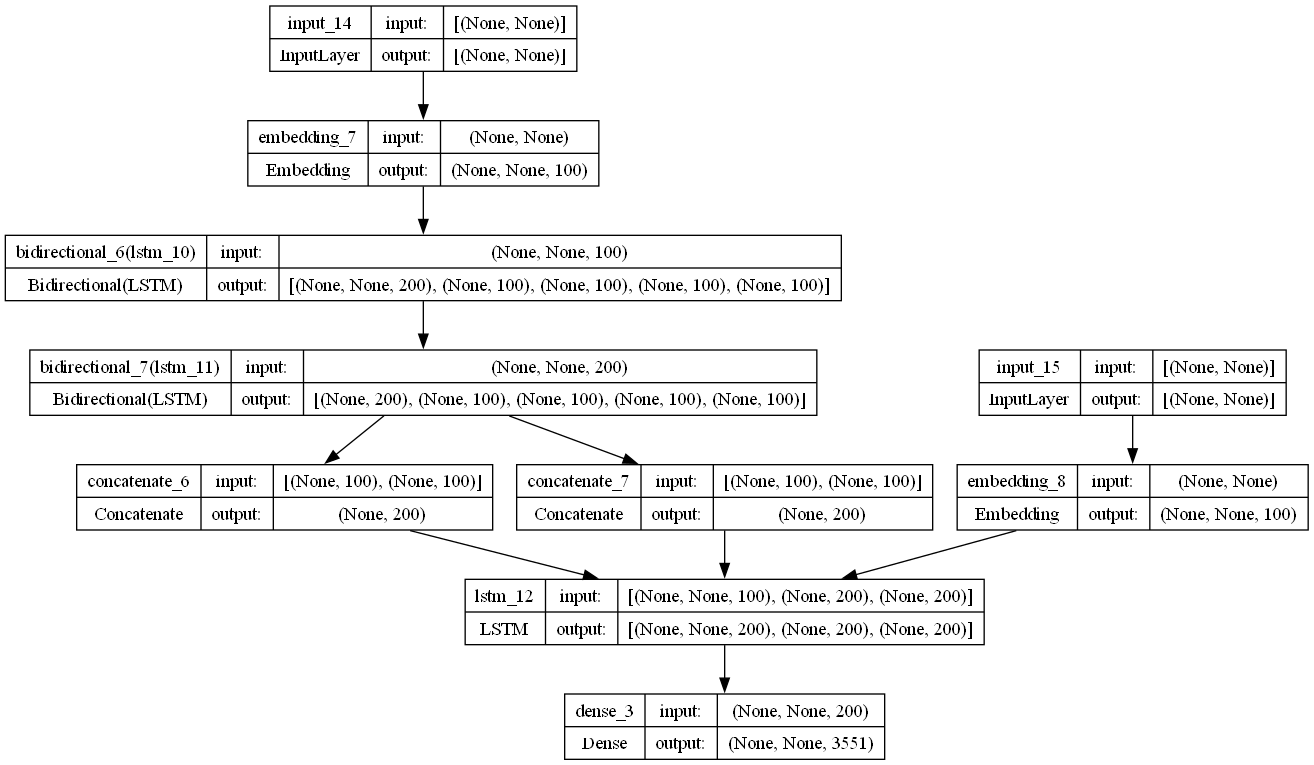

In [223]:
# Assuming 'model' is your Keras model
plot_model(translator, to_file='translator.png', show_shapes=True, show_layer_names=True)

#print("Model plot saved as 'model_plot.png'.")


In [224]:
train_samples=len(X_train)
val_samples=len(X_test)
batch_size=128
epochs=250
steps_per_epoch=train_samples//batch_size,
validation_steps=val_samples//batch_size

In [225]:
train_samples

2400

In [226]:
val_samples

600

In [229]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop if val_loss doesn't improve for 10 epochs
    restore_best_weights=True,  # Restore best model weights after stopping
    verbose=1
)

#callbacks=[early_stopping]  # Add early stopping here

In [230]:
# Train the model with early stopping
history = translator.fit(
    generate_batch(X_train, y_train, batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=80,
    validation_data=generate_batch(X_test, y_test, batch_size),
    validation_steps=len(X_test) // batch_size,
    callbacks=[early_stopping]    
)

Epoch 1/80
18/18 [==============================] - 19s 1s/step - loss: 0.5639 - accuracy: 0.1158 - val_loss: 0.5664 - val_accuracy: 0.1232
Epoch 2/80
18/18 [==============================] - 7s 403ms/step - loss: 0.5559 - accuracy: 0.1195 - val_loss: 0.5649 - val_accuracy: 0.1275
Epoch 3/80
18/18 [==============================] - 7s 397ms/step - loss: 0.5474 - accuracy: 0.1231 - val_loss: 0.5622 - val_accuracy: 0.1292
Epoch 4/80
18/18 [==============================] - 7s 403ms/step - loss: 0.5342 - accuracy: 0.1265 - val_loss: 0.5605 - val_accuracy: 0.1320
Epoch 5/80
18/18 [==============================] - 7s 401ms/step - loss: 0.5317 - accuracy: 0.1266 - val_loss: 0.5590 - val_accuracy: 0.1339
Epoch 6/80
18/18 [==============================] - 7s 403ms/step - loss: 0.5223 - accuracy: 0.1290 - val_loss: 0.5592 - val_accuracy: 0.1328
Epoch 7/80
18/18 [==============================] - 7s 404ms/step - loss: 0.5147 - accuracy: 0.1318 - val_loss: 0.5556 - val_accuracy: 0.1365
Epoch 8/

In [231]:
translator.save_weights('translator_weights.h5')
'''Saving the weights of the trained model'''

'Saving the weights of the trained model'

In [232]:
translator.load_weights('translator_weights.h5')

# Encoder Model Implementation Refernece 
# cell[33]
```python
# Encoder Input
encoder_inputs = Input(shape=(None,))  

# Embedding Layer
enc_emb = Embedding(input_dim=num_encoder_tokens+1, output_dim=latent_dim, mask_zero=True)(encoder_inputs)

# First Bidirectional LSTM Layer (returns sequences)
encoder_lstm1 = Bidirectional(LSTM(units=latent_dim, return_sequences=True, return_state=True))
encoder_outputs1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

# Second Bidirectional LSTM Layer (returns sequences and final states)
encoder_lstm2 = Bidirectional(LSTM(units=latent_dim, return_sequences=False, return_state=True))
encoder_outputs2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_outputs1)

# Concatenate final forward and backward states
state_h = Concatenate()([forward_h2, backward_h2])
state_c = Concatenate()([forward_c2, backward_c2])

# Final encoder states
encoder_states = [state_h, state_c]
```


# Decoder Model Implementation Reference
# cell[34]
```python

# Decoder Inputs
decoder_inputs = Input(shape=(None,))

# Embedding layer for decoder inputs
decoder_emb_layer = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim, mask_zero=True)
dec_emb = decoder_emb_layer(decoder_inputs)

# By setting mask_zero=True, the model ignores padding 0s in the target sentence
'''
We set up our decoder to return full output sequences 
and internal states. While we don't use the returned states 
in training, they are necessary for inference.
'''

# Adjust the LSTM units to match the new encoder state size (2 * latent_dim)
decoder_lstm = LSTM(units=2 * latent_dim, return_sequences=True, return_state=True)

# Since encoder states are now twice the size, they are passed directly
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Dense layer for final output
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

'''
Define the model that will turn 'encoder_input_data' & 
'decoder_input_data' into 'decoder_target_data'.
'''

# Define the full translator model
translator = Model([encoder_inputs, decoder_inputs], decoder_outputs)
```


In [233]:
#Encode the input sequence to get the "Context vectors"
encoder_model=Model(encoder_inputs, encoder_states)

# Adjust decoder state inputs to match bidirectional encoder
decoder_state_input_h = Input(shape=(2 * latent_dim,))
decoder_state_input_c = Input(shape=(2 * latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = decoder_emb_layer(decoder_inputs)  # Decoder embeddings

# Decoder LSTM should also have 2 * latent_dim units
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                     initial_state=decoder_states_inputs)

decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)  # Softmax layer for word prediction

# Final Inference Decoder Model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,  # Inputs: target word + previous states
    [decoder_outputs2] + decoder_states2  # Outputs: predicted word + updated states
)


In [234]:
def decode_sequence(input_seq):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)

    # Create target sequence with only the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['START_']  # Replace with your start token

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' ' + sampled_word

        # Stop if the end token is generated or sentence is too long
        if (sampled_word == '_END'):
            stop_condition = True

        # Update the target sequence (feeding back predicted word)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states (important!)
        states_value = [h, c]  # Update decoder state for next prediction

    return decoded_sentence


In [235]:
data=shuffle(data)

In [236]:
test_gen = generate_batch(data.English, data.Hindi, batch_size = 1)
k=0

In [237]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', data.English[k:k+1].values[0])
print('Actual Hindi Translation:', data.Hindi[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 46ms/step
Input English sentence: id rather not meet him
Actual Hindi Translation:  हो सके तो मैं उससे मिलना नहीं चाहूँगा 
Predicted Hindi Translation:  मुझे उसे बहुत लिए नहीं है 


In [238]:
test_train = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [239]:
k+=15
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Hindi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 48ms/step
Input English sentence: he deals in furniture
Actual Hindi Translation:  वो फ़र्निचर का व्यापार करता है 
Predicted Hindi Translation:  वह अपने लिए नहीं नहीं है 


In [240]:
l=['i','love','you']

for i in l:
    x=input_token_index.get(i,0)
    print(x)
   

1263
1532
2923


In [241]:
l=['i','love','you']
decoded_sentence = decode_sequence([[1263,1532,2923]])
decoded_sentence

1/1 [==============================] - 0s 47ms/step


' मैं उसे प्यार है _END'